In [183]:
from wordcloud import WordCloud, STOPWORDS
import sqlite3
import pandas as pd
import os
import gzip
import json
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import HTML
import matplotlib.ticker as ticker
import warnings
import plotly.io as pio

pio.templates.default = "plotly_dark"
warnings.filterwarnings('ignore')

In [2]:
@ticker.FuncFormatter
def thousand_formatter(x, pos):
    """Format to thousands format
    """
    return "%.1fK" % (x/1E3)

@ticker.FuncFormatter
def million_formatter(x, pos):
    """Format to thousands format
    """
    return "%.1fM" % (x/1E6)

In [3]:
HTML('''
<script
    src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js ">
</script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
''')

In [4]:
ARXIV_DATASET = '/mnt/data/public/arxiv/arxiv-metadata-oai-snapshot.json'
OPENALEX_PATH = '/mnt/data/public/openalex/data/works/updated_date=2023-08-29/'

In [5]:
# Any title suggestions?

<a name="top"></a>
## Table of Contents
***
[ref0]: #abs
- [Executive Summary][ref0]

[ref1]: #intro
- [Introduction][ref1]

[ref2]: #probs
- [Problem Statement][ref2]

[ref3]: #dsscope
- [Dataset Exploration and Scope][ref3]

[ref4]: #meth
- [Methodology][ref4]

    [ref4_1]: #meth_1
    - [Setup sqlite3 connection][ref4_1]

    [ref4_2]: #meth_2
    - [Prepare OpenAlex Dataset][ref4_2]    
    
    [ref4_3]: #meth_3
    - [Prepare ArXiv Dataset][ref4_3]

[ref5]: #analy
- [Analysis][ref5]

    [ref5_1]: #analy_1
    - [Open Access Articles][ref5_1]

    [ref5_2]: #analy_2
    - [ArXiv Open Access Articles][ref5_2]    
    
    [ref5_3]: #analy_3
    - [Not Open Access Arrticles][ref5_3] 
    
    [ref5_4]: #analy_4
    - [Calculation of Open Access, Not Open Access and ArxiV only Percentages of Indexed Article][ref5_4] 
    
    [ref5_5]: #analy_5
    - [Calculation of Cited by Ratio][ref5_5]
    
    [ref5_6]: #analy_6
    - [Get the proportion of papers with funding][ref5_6]
    
    
    [ref5_7]: #analy_7
    - [Visualizations][ref5_7] 
    
        [ref5_7_1]: #analy_7_1
        - [Cited by Ratios and Open Access Percentages][ref5_7_1]
        
        [ref5_7_2]: #analy_7_2
        - [Funding Percentages][ref5_7_2]
        
        [ref5_7_3]: #analy_7_3
        - [Top 5 Insights][ref5_7_3]
        
[ref6]: #conc
- [Conclusion][ref6]

[ref7]: #rfn
- [References][ref7]

# An Inquiry into the State of Open Access Research from 2022 to the Present: Insights from OpenAlex and ArXiV

<a name="abs"></a>
## Executive Summary
***
In this lab report, we explore the state of open access research in the world by investigating data from the ArXiV and OpenAlex repositories for the period 2022 to present. Articles are classified as open access and paid access. The percentage of open access articles coming from ArXiv are identified. Insights are then obtained from the processed data - `Cited by Rations`, `Open Access Percentage`, `Funding Percentages` and `Top 5 countries and concepts`.

The report finds that roughly fewer than half of all articles are open access, with ArXiV only contributing a small percentage of the open access contribution of new research generated from 2022 to the present. Suprisingly, new articles that are behind a paywall are cited more times (0.71 times) than open acess articles (0.42 times), though open access articles coming specifically from ArXiv significantly gets cited more often than its OpenAlex-indexed counterparts (1.16 times).

In terms of articles with grants/funding, it is observed that a significant percentage of articles are unfunded (90.34%). On the funded articles it is observed that paid access articles' funding percentage is significantly high (68.70%). Further, this lab report may be used to track future development for both repositories. Finally, of all the partitions ArXiv articles are getting good funding (44.55% funded) compared to open access (6.31% funded) and paid access (12.36%) in general. 

This report also identified the US and China as top country of origin for both open access and not open access articles. For research themes and concepts for the open access and not open access group was Computer Science and for ArXiV only group the top concept was Physics.  

[ref]: #top
[top][ref]

<a name="intro"></a>
## Introduction
***
Knowledge is a crucial commodity to fuel economic growth and development through technological and human capital advancement. The widespread dissemination of research and knowledge has the potential to yield large and potentially recurring positive externalities. However, access to some portions of new and existing research knowledge is barred by financial walls, limiting the consumers of research knowledge by no small degree only to those who can afford it. While the economics behind the business of research publication is undeniably complex and necessitates the existence of paywalls, it is equally undeniable that these financial barriers are denying people from less affluent societies the opportunity to leverage research findings to fuel development via further knowledge generation or practical applications.

[ref]: #top
[top][ref]

<a name="probs"></a>
## Research Questions
***
What is the state of open access research according to ArXiV and OpenAlex for the period 2022 to present?
* What percentage of OpenAlex articles are open access?
* What percentage open access articles are available for free in ArXiV?
* Which group of articles (open access, paid access, ArXiV only) receive funding/grants?
* Which research themes or concepts dominate each group (open access, paid access, ArXiV only)?
* Which countries publish the most number of articles in each group (open access, paid access, ArXiV only)?

Does being open access have a significant impact on the usability of new research work?

[ref]: #top
[top][ref]

<a name="dsscope"></a>
## Dataset Exploration and Scope
***

### OpenAlex (primary dataset)
- <u>OpenAlex</u> is an indexing service for the world's research.
- Contents of `/mnt/data/public/openalex/data/works/updated date=2023-08-29/*` for data of individual scholary submissions
- Selected this partition as latest snapshot has too many parts and is temporaly expensive to load
- `publication_year` is from 2022-Present timeframe (08 Nov 2023)

In [6]:
with gzip.open(
    OPENALEX_PATH+'part_000.gz',
    'r'
) as f:
    for line in f:
        print("OpenAlex Fields:")
        article = json.loads(line)
        display(list(article.keys()))
        break

OpenAlex Fields:


['is_retracted',
 'apc_list',
 'countries_distinct_count',
 'is_paratext',
 'cited_by_api_url',
 'counts_by_year',
 'biblio',
 'primary_location',
 'language',
 'related_works',
 'title',
 'type',
 'corresponding_institution_ids',
 'summary_stats',
 'publication_date',
 'open_access',
 'authorships',
 'id',
 'institutions_distinct_count',
 'abstract_inverted_index',
 'sustainable_development_goals',
 'mesh',
 'grants',
 'best_oa_location',
 'cited_by_count',
 'concepts_count',
 'referenced_works',
 'type_crossref',
 'referenced_works_count',
 'display_name',
 'doi_registration_agency',
 'publication_year',
 'concepts',
 'authors_count',
 'ids',
 'locations_count',
 'locations',
 'corresponding_author_ids',
 'updated_date',
 'created_date',
 'apc_paid',
 'updated',
 'doi']

See https://docs.openalex.org/api-entities/works/work-object for reference\
Important fields to utilize:
- `authorships` - list of authors associated to the article
    - More info about authr object fields: https://docs.openalex.org/api-entities/authors/author-object
    - Notable fields to be leveraged:
        - <u>`countries`</u> - list of country codes, main country is the first element of the list
    - This lab report will get the top contry code in countries to associate a `extracted_country` to the article

For the article above the `extracted_country` would be `US`:

In [7]:
authorships = article['authorships']
print('Title')
display(article['title'])
print('extracted_country')
display(authorships[0]['countries'][0])

Title


'The obligatory role of endothelial cells in the relaxation of arterial smooth muscle by acetylcholine'

extracted_country


'US'

- `cited_by_count` - These are the times that other works have cited this work

For the article above the `cited_by_count` would be:

In [8]:
article['cited_by_count']

11260

- `grants` - list of funders
    - More info about funde object: https://docs.openalex.org/api-entities/funders
    - Not all works has this if not present then `top_funder` is null
    - Notable fields:
        - `display_name` - name of funder

In [9]:
article['grants']

[]

- `open_access`
    - More info about open access object: https://docs.openalex.org/api-entities/works/work-object#the-openaccess-object
    - Not all works has this if not present then `is_oa` is False
    - Notable fields:
        - `is_oa` - whether paper is open access

In [10]:
article['open_access']

{'oa_status': 'closed',
 'is_oa': False,
 'oa_url': None,
 'any_repository_has_fulltext': False}

- `concepts` - list of research concepts associated to the article
    - More info about concept object fields: https://docs.openalex.org/api-entities/concepts/concept-object
    - Notable fields to be leveraged:
        - <u>`level`</u> - The `level` in the concept tree where this concept lives. Lower-level concepts are more general, and higher-level concepts are more specific. `Computer Science` has a level of 0; `Java Bytecode` has a level of 5. Level 0 concepts have no ancestors and level 5 concepts have no descendants.
        - <u>`score`</u> - The strength of association witht the article
        - <u>`display_name`</u> - The actual concept
    - This lab report will get the top scored level 0 concept to associated a `top_concept` to the article

For the article above the `top_concept` would be `Chemistry`:

In [11]:
concepts = article['concepts']
level_0_concepts = sorted(
    [d for d in concepts if d['level'] == 0],
    key=lambda x: x['score'],
    reverse=True
)
print('Title')
display(article['title'])
print('top_concept:')
display(level_0_concepts[0])

Title


'The obligatory role of endothelial cells in the relaxation of arterial smooth muscle by acetylcholine'

top_concept:


{'score': 0.54185396,
 'level': 0,
 'id': 'https://openalex.org/C185592680',
 'display_name': 'Chemistry',
 'wikidata': 'https://www.wikidata.org/wiki/Q2329'}

[ref]: #top
[top][ref]

### ArXiv (supplementary dataset)
- <u>ArXiv</u> on the other hand is an open access to scholarly articles where you can download the PDFs free of charge.
- From `/mnt/data/public/arxiv/arxiv-metadata-oai-snapshot.json`
- `v1 date` is from 2022-Present timeframe

Exploring fields in ArXiv Dataset:

In [12]:
with open(ARXIV_DATASET, 'r') as f:
    for i, line in enumerate(f):
        article = json.loads(line)
        print("ArXiv Fields:")
        display(list(article.keys()))
        break

ArXiv Fields:


['id',
 'submitter',
 'authors',
 'title',
 'comments',
 'journal-ref',
 'doi',
 'report-no',
 'categories',
 'license',
 'abstract',
 'versions',
 'update_date',
 'authors_parsed']

Important fields to utilize:
- `id` - ArXiv id (used to find the open access article in ArXiv)
- `doi` - digital object identifier of the article (join key)
- `versions` - list of versions of the article, v1 is the when the article was first seen 
    - in this report the v1 date will be treated as the publication date/year

In [13]:
article['versions']

[{'version': 'v1', 'created': 'Mon, 2 Apr 2007 19:18:42 GMT'},
 {'version': 'v2', 'created': 'Tue, 24 Jul 2007 20:10:27 GMT'}]

[ref]: #top
[top][ref]

<a name="meth"></a>
## Methodology
***

<a name="meth_1"></a>
### Setup sqlite3 connection

Setup sqlite connection in `lab1.db` 

In [54]:
db_conn = sqlite3.connect('lab1.db')

[ref]: #top
[top][ref]

<a name="meth_2"></a>
### Prepare OpenAlex Dataset (~40mins)

Helper Functions for OpenAlex Dataset Extraction:

In [15]:
def extract_countries(row):
    """Transform `authorships` column into `extracted_countries` column.
    """
    if row['authorships'] and len(row['authorships']) > 0:
        country_list = row['authorships'][0]['countries']
        if len(country_list) > 0:
            return country_list[0]
        else:
            return None
    else:
        return None


def extract_top_concept(row):
    """Transform `concepts` column into `top_concept` column.
    """
    concepts = row['concepts']
    if concepts and len(concepts) > 0:
        level_0_concepts = sorted(
            [d for d in concepts if d['level'] == 0],
            key=lambda x: x['score'],
            reverse=True
        )
        top_concept = level_0_concepts[0]['display_name']
        return top_concept
    else:
        return None


def extract_grants(row):
    """Transform `grants` column into `top_funder` column.
    """
    if len(row.get('grants', [])) > 0:
        return row['grants'][0]['funder_display_name']
    return None


def extract_is_oa(row):
    if len(row.get('open_access', [])) > 0:
        return row['open_access']['is_oa']
    return False

OpenAlex Dataset from partition `2023-08-29`in `/mnt/data/public/openalex/data/works/updated_date=2023-08-29/` directory

In [16]:
works_parts = os.listdir(
    OPENALEX_PATH
)
display(works_parts)

['part_009.gz',
 'part_007.gz',
 'part_005.gz',
 'part_000.gz',
 'part_002.gz',
 'part_001.gz',
 'part_008.gz',
 'part_006.gz',
 'part_004.gz',
 'part_003.gz']

Extract OpenAlex Dataset to Pandas Dataframe
- Select `title`, `doi`, `authoriships`, `concepts` and `publication_year` (relevant columns only)
- Filter where `publication_year` is from 2022-Present
- Remove articles without doi (can't be joined anyway)
- Create `top_concept` column extracted from `concepts` column transformation
- Create `extracted_countries` column extracted from `authorships` column transformation
- Create `top_funder` column extracted from `grants` column transformation
- Create `is_oa` column extracted from `open_access` column transformation

In [17]:
openalex_df_list = []

for work_path in works_parts:
    display(work_path)
    openalex_chunks = pd.read_json(
        OPENALEX_PATH+work_path,
        lines=True,
        chunksize=60000,
        compression='gzip',
    )

    for df in openalex_chunks:
        df = df[df['publication_year'] >= 2022]
        df = df[df['doi'].notna()]
        df = df[[
            'title', 'doi', 'authorships', 'concepts', 'publication_year',
            'cited_by_count', 'grants', 'open_access'
        ]]
        if not df.empty:
            df['top_concept'] = df.apply(extract_top_concept, axis=1)
            df['extracted_countries'] = df.apply(extract_countries, axis=1)
            df['top_funder'] = df.apply(extract_grants, axis=1)
            df['is_oa'] = df.apply(extract_is_oa, axis=1)
            df = df[df['extracted_countries'].notna()]
            openalex_df_list.append(df)


openalex_df = pd.concat(openalex_df_list, ignore_index=True)
display(openalex_df)

'part_009.gz'

'part_007.gz'

'part_005.gz'

'part_000.gz'

'part_002.gz'

'part_001.gz'

'part_008.gz'

'part_006.gz'

'part_004.gz'

'part_003.gz'

,title,doi,authorships,concepts,publication_year,cited_by_count,grants,open_access,top_concept,extracted_countries,top_funder,is_oa
0,O pojęciu godności narodowej w polskiej myśli ...,https://doi.org/10.11649/sn.2012.007,[{'institutions': [{'lineage': ['https://opena...,"[{'score': 0.94091177, 'level': 2, 'id': 'http...",2022,0,[],"{'oa_status': 'gold', 'is_oa': True, 'oa_url':...",Sociology,PL,None,True
1,“Höchst unerwünschte Ausländer”: The Fate of E...,https://doi.org/10.11649/sn.2012.017,[{'institutions': [{'lineage': ['https://opena...,"[{'score': 0.818589, 'level': 3, 'id': 'https:...",2022,0,[],"{'oa_status': 'gold', 'is_oa': True, 'oa_url':...",Political science,DE,None,True
2,Piwo i gospoda w kulturze czeskiej – polskie w...,https://doi.org/10.11649/sn.2012.021,[{'institutions': [{'lineage': ['https://opena...,"[{'score': 0.96974075, 'level': 2, 'id': 'http...",2022,0,[],"{'oa_status': 'gold', 'is_oa': True, 'oa_url':...",Sociology,PL,None,True
3,La edición y traducción de textos médicos medi...,https://doi.org/10.58576/cilengua.vi4.169,[{'institutions': [{'lineage': ['https://opena...,"[{'score': 0.52048725, 'level': 0, 'id': 'http...",2023,0,[],"{'oa_status': 'bronze', 'is_oa': True, 'oa_url...",Art,ES,None,True
4,Funkcje wypowiedzi katechetycznej,https://doi.org/10.21852/sem.2009.26.5,"[{'institutions': [], 'raw_affiliation_strings...","[{'score': 0.51094407, 'level': 1, 'id': 'http...",2023,0,[],"{'oa_status': 'closed', 'is_oa': True, 'oa_url...",Philosophy,GB,None,True
...,...,...,...,...,...,...,...,...,...,...,...,...
127354,Morfología histórica del verbo cocer. Homonimi...,https://doi.org/10.58576/cilengua.vi8.123,[{'institutions': [{'lineage': ['https://opena...,"[{'score': 0.703625, 'level': 1, 'id': 'https:...",2023,0,[],"{'oa_status': 'bronze', 'is_oa': True, 'oa_url...",Philosophy,ES,None,True
127355,Nomenclature of Ion Channels (IUPHAR Scheme),https://doi.org/10.1007/978-1-0716-1006-0_234,[{'institutions': [{'lineage': ['https://opena...,"[{'score': 0.56369793, 'level': 3, 'id': 'http...",2022,0,[],"{'oa_status': 'closed', 'is_oa': False, 'oa_ur...",Computer science,GB,None,False
127356,ÜNİVERSİTELERLE SANAYİ KURULUŞLARI ARASINDA İŞ...,https://doi.org/10.17740/eas.soc.2015-v2-06,[{'institutions': [{'lineage': ['https://opena...,"[{'score': 0.36918116, 'level': 1, 'id': 'http...",2022,0,[],"{'oa_status': 'bronze', 'is_oa': True, 'oa_url...",Physics,TR,None,True
127357,Las autoridades del Gran Diccionario de la Len...,https://doi.org/10.58576/cilengua.vi7.133,[{'institutions': [{'lineage': ['https://opena...,"[{'score': 0.8275969999999999, 'level': 1, 'id...",2023,0,[],"{'oa_status': 'bronze', 'is_oa': True, 'oa_url...",Art,IL,None,True


Remove problematic columns `authorships` and `concepts` (list type) then save to sqlite db as `openalex` table

In [18]:
openalex_df = openalex_df.drop(
    columns=[
        'authorships',
        'concepts',
        'grants',
        'open_access'
    ]
)

In [19]:
openalex_df.to_sql('openalex', db_conn, if_exists='replace', index=False)

127359

[ref]: #top
[top][ref]

<a name="meth_3"></a>
### Prepare ArXiv Dataset (~5mins)

Helper functions for ArXiv Dataset Extraction:

In [20]:
def extract_created_date(versions):
    """Transform `versions` column into `v1 date` column.
    """
    for version in versions:
        if version['version'] == 'v1':
            return version['created']
    return None

Extract ArXiv Dataset to Pandas Dataframe
- Load to dataframe using `pd.read_json` leveraging `chunksize` param
- `v1 date` column created based on transformation done on `versions` column
- `doi` column transformed to match the format seen in OpenAlex (prefixing `https://doi.org/`), this will be used as the join key
- Filter df where `v1 date` is from 2022-Present
- `id` column renamed to `arxiv_id`

In [21]:
# 24 chunks of 100k
arxiv_chunks = pd.read_json(
    ARXIV_DATASET,
    lines=True,
    chunksize=100000
)

arxiv_df_list = []

for df in arxiv_chunks:
    df = df[df['doi'].notna()]
    df['v1 date'] = df['versions'].apply(extract_created_date)
    df['v1 date'] = pd.to_datetime(df['v1 date'], format='mixed')
    df['doi'] = "https://doi.org/"+df['doi']
    df = df[df['v1 date'] >= '2022-01-01']
    arxiv_df_list.append(df)

arxiv_df = pd.concat(arxiv_df_list, ignore_index=True)
rename_dict = {
    'id': 'arxiv_id',
}
arxiv_df.rename(
    columns=rename_dict,
    inplace=True,
)
arxiv_df

,arxiv_id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,v1 date
0,2201.00079,Seong-Yeop Jeong,"Seong-Yeop Jeong, Daniel Verscharen, Christian...",The Kinetic Expansion of Solar-Wind Electrons:...,Accepted in ApJ,None,https://doi.org/10.3847/1538-4357/ac4805,None,physics.space-ph,http://creativecommons.org/licenses/by/4.0/,We propose a transport theory for the kineti...,"[{'version': 'v1', 'created': 'Sat, 1 Jan 2022...",2022-03-30,"[[Jeong, Seong-Yeop, ], [Verscharen, Daniel, ]...",2022-01-01 00:14:18+00:00
1,2201.00085,Fei Shi,"Fei Shi, Mao-Sheng Li, Lin Chen, and Xiande Zhang",Strong quantum nonlocality for unextendible pr...,None,Journal of Physics A: Mathematical and Theoret...,https://doi.org/10.1088/1751-8121/ac3bea,None,quant-ph,http://creativecommons.org/licenses/by/4.0/,A set of multipartite orthogonal product sta...,"[{'version': 'v1', 'created': 'Sat, 1 Jan 2022...",2022-01-04,"[[Shi, Fei, ], [Li, Mao-Sheng, ], [Chen, Lin, ...",2022-01-01 01:18:37+00:00
2,2201.00091,Tanay Roy,"Tanay Roy, Liang Jiang, David I. Schuster",Deterministic Grover search with a restricted ...,"6 pages, 4 figures",None,https://doi.org/10.1103/PhysRevResearch.4.L022013,None,quant-ph,http://creativecommons.org/licenses/by/4.0/,Grover's quantum search algorithm provides a...,"[{'version': 'v1', 'created': 'Sat, 1 Jan 2022...",2022-11-15,"[[Roy, Tanay, ], [Jiang, Liang, ], [Schuster, ...",2022-01-01 02:04:11+00:00
3,2201.00093,Alex Sheng,"Alex Sheng, Derek He",Distributed Evolution Strategies Using TPUs fo...,Published in Proceedings of the 2020 IEEE Symp...,2020 IEEE Symposium Series on Computational In...,https://doi.org/10.1109/SSCI47803.2020.9308334,None,cs.NE cs.AI cs.LG,http://arxiv.org/licenses/nonexclusive-distrib...,Meta-learning traditionally relies on backpr...,"[{'version': 'v1', 'created': 'Sat, 1 Jan 2022...",2022-01-04,"[[Sheng, Alex, ], [He, Derek, ]]",2022-01-01 02:14:02+00:00
4,2201.001,Xiaoqiang Wang,"Xiaoqiang Wang, Lei Zhu, Siliang Tang, Huazhu ...",Boosting RGB-D Saliency Detection by Leveragin...,Accepted by IEEE TIP,None,https://doi.org/10.1109/TIP.2021.3139232,None,eess.IV cs.CV,http://arxiv.org/licenses/nonexclusive-distrib...,Training deep models for RGB-D salient objec...,"[{'version': 'v1', 'created': 'Sat, 1 Jan 2022...",2022-01-04,"[[Wang, Xiaoqiang, ], [Zhu, Lei, ], [Tang, Sil...",2022-01-01 03:02:27+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83128,2310.03663,Pallav Bera,"Pallav Kumar Bera, Vajendra Kumar, Samita Rani...",Autoregressive Coefficients based Intelligent ...,None,"IEEE Transactions on Power Delivery, 2023",https://doi.org/10.1109/TPWRD.2023.3321844,None,eess.SP,http://creativecommons.org/licenses/by/4.0/,Protective relays can mal-operate for transm...,"[{'version': 'v1', 'created': 'Thu, 5 Oct 2023...",2023-10-06,"[[Bera, Pallav Kumar, ], [Kumar, Vajendra, ], ...",2023-10-05 16:39:51+00:00
83129,2310.03670,Yang Liu,"Yang Liu, Chen Chen, Can Wang, Xulin King, Men...",Regress Before Construct: Regress Autoencoder ...,None,In Proceedings of the 31st ACM International C...,https://doi.org/10.1145/3581783.3612106,None,cs.CV,http://arxiv.org/licenses/nonexclusive-distrib...,Masked Autoencoders (MAE) have demonstrated ...,"[{'version': 'v1', 'created': 'Mon, 25 Sep 202...",2023-10-06,"[[Liu, Yang, ], [Chen, Chen, ], [Wang, Can, ],...",2023-09-25 17:23:33+00:00
83130,2310.03688,Boaz Rafaely,Boaz Rafaely and Koby Alhaiany,Speaker localization using direct path dominan...,None,"Signal Processing, vol. 143, pp. 42 - 47, 2018",https://doi.org/10.1016/j.sigpro.2017.08.010,None,eess.AS cs.SD,http://creativecommons.org/licenses/by/4.0/,Estimation of the direction-of-arrival (DoA)...,"[{'version': 'v1', 'created': 'Thu, 5 Oct 2023...",2023-10-06,"[[Rafaely, Boaz, ], [Alhaiany, Koby, ]]",2023-10-05 17:09:50+00:00
83131,2310.03700,Evgeny Stemasov,"Evgeny Stemasov, Jessica Hohn, Maurice Cordts,...",BrickStARt: Enablin

Remove problematic columns `versions` and `authors_parsed` (list type) then save to sqlite db as `arxiv` table

In [22]:
arxiv_df = arxiv_df.drop(columns=['versions', 'authors_parsed'])

In [23]:
arxiv_df.to_sql('arxiv', db_conn, if_exists='replace', index=False)

83133

[ref]: #top
[Back to Table of Contents][ref]

<a name="analy"></a>
## Analysis
***

In [24]:
sql_str = """
SELECT *
FROM
openalex o
"""
total_df = pd.read_sql(sql_str, db_conn)
total_count = len(total_df)
total_count

127359

<a name="analy_1"></a>
### Open Access Articles

OpenAlex Indexed Articles that is is_oa = 1 and in ArXiv (6 rows was is_oa = 0 but available in ArXiv)

In [25]:
sql_str = """
SELECT
    a.arxiv_id,
    o.title,
    o.top_concept,
    o.extracted_countries,
    o.top_funder,
    o.is_oa,
    o.cited_by_count,
    coalesce(o.doi, a.doi) as doi
FROM
openalex o
LEFT JOIN arxiv a
    ON a.doi = o.doi
WHERE o.is_oa = 1 OR arxiv_id is not null
"""
df_oa = pd.read_sql(sql_str, db_conn)
count_oa = len(df_oa)
display(count_oa)
display(df_oa.head(5))

58834

,arxiv_id,title,top_concept,extracted_countries,top_funder,is_oa,cited_by_count,doi
0,None,O pojęciu godności narodowej w polskiej myśli ...,Sociology,PL,None,1,0,https://doi.org/10.11649/sn.2012.007
1,None,“Höchst unerwünschte Ausländer”: The Fate of E...,Political science,DE,None,1,0,https://doi.org/10.11649/sn.2012.017
2,None,Piwo i gospoda w kulturze czeskiej – polskie w...,Sociology,PL,None,1,0,https://doi.org/10.11649/sn.2012.021
3,None,La edición y traducción de textos médicos medi...,Art,ES,None,1,0,https://doi.org/10.58576/cilengua.vi4.169
4,None,Funkcje wypowiedzi katechetycznej,Philosophy,GB,None,1,0,https://doi.org/10.21852/sem.2009.26.5


Top 5 countries:

In [26]:
top_5_c_oa = df_oa['extracted_countries'].value_counts()[0:5]
list(top_5_c_oa.index)

['US', 'CN', 'ID', 'IN', 'GB']

Top 5 concepts:

In [27]:
top_5_con_oa = df_oa['top_concept'].value_counts()[0:5][::-1]
list(top_5_con_oa.index)

['Mathematics', 'Geography', 'Chemistry', 'Medicine', 'Computer science']

In [28]:
df_oa.to_sql('openaccess', db_conn, if_exists='replace', index=False)

58834

<a name="analy_2"></a>
### ArXiv Open Access Articles

In [29]:
sql_str = """
SELECT
    a.arxiv_id,
    a.title as tit1,
    o.title as tit2,
    o.top_concept,
    o.extracted_countries,
    o.top_funder,
    o.is_oa,
    coalesce(o.doi, a.doi) as doi
FROM
openaccess o
INNER JOIN arxiv a
    on o.doi = a.doi
"""
df_arxiv_only = pd.read_sql(sql_str, db_conn)
df_arxiv_only
count_arxiv_only = len(df_arxiv_only)
display(count_arxiv_only)
display(df_arxiv_only.head(5))

330

,arxiv_id,tit1,tit2,top_concept,extracted_countries,top_funder,is_oa,doi
0,2303.04741,GETNext: Trajectory Flow Map Enhanced Transfor...,GETNext,Computer science,NZ,None,1,https://doi.org/10.1145/3477495.3531983
1,2306.11733,ARA-residual power series method for solving p...,ARA-residual power series method for solving p...,Mathematics,JO,None,1,https://doi.org/10.1016/j.aej.2022.07.022
2,2203.02132,Thermal Relaxation of Dark Matter Admixed Neut...,Thermal relaxation of dark matter admixed neut...,Physics,IN,None,1,https://doi.org/10.1093/mnras/stac1013
3,2204.02719,A study of the F-giant star $\theta$ Scorpii A...,A study of the F-giant star θ Scorpii A: a pos...,Physics,AU,None,1,https://doi.org/10.1093/mnras/stac991
4,2205.04868,Modeling nonlocal behavior in epidemics via a ...,Modeling nonlocal behavior in epidemics via a ...,Computer science,BR,None,1,https://doi.org/10.1016/j.cma.2022.115541


Top 5 countries

In [30]:
top_5_c_arx = df_arxiv_only['extracted_countries'].value_counts()[0:5]
list(top_5_c_arx.index)

['US', 'CN', 'IN', 'JP', 'AU']

Top 5 concepts

In [31]:
top_5_con_arx = df_arxiv_only['top_concept'].value_counts()[0:5][::-1]
list(top_5_con_arx.index)

['Geology', 'Materials science', 'Mathematics', 'Computer science', 'Physics']

[ref]: #top
[top][ref]

<a name="analy_3"></a>
### Not Open Access Articles

In [32]:
sql_str = """
SELECT
    a.arxiv_id,
    o.title,
    o.top_concept,
    o.extracted_countries,
    o.top_funder,
    o.is_oa,
    coalesce(o.doi, a.doi) as doi
FROM
openalex o
LEFT JOIN arxiv a
    ON a.doi = o.doi
WHERE a.doi IS NULL AND
o.is_oa = 0
"""
df_not_oa = pd.read_sql(sql_str, db_conn)
count_not_oa = len(df_not_oa)
display(count_not_oa)
display(df_not_oa.head(5))

68525

,arxiv_id,title,top_concept,extracted_countries,top_funder,is_oa,doi
0,None,Cheese Analogs,Chemistry,IE,None,0,https://doi.org/10.1016/b978-0-12-818766-1.000...
1,None,Lactic Acid Bacteria: Exopolysaccharides,Chemistry,DE,None,0,https://doi.org/10.1016/b978-0-08-100596-5.229...
2,None,Geohelminths,Biology,IT,None,0,https://doi.org/10.1016/b978-0-12-818731-9.000...
3,None,The migration trajectory of the Benin Bronzes,Sociology,US,None,0,https://doi.org/10.1093/migration/mnab016
4,None,Sleep in infants and children with chronic res...,Medicine,US,None,0,https://doi.org/10.1016/b978-0-12-822963-7.002...


[ref]: #top
[top][ref]

Top 5 countries:

In [33]:
top_5_c_not_oa = df_not_oa['extracted_countries'].value_counts()[0:5]
list(top_5_c_not_oa.index)

['CN', 'US', 'IN', 'DE', 'JP']

Top 5 concepts:

In [34]:
top_5_con_not_oa = df_not_oa['top_concept'].value_counts()[0:5][::-1]
list(top_5_con_not_oa.index)

['Psychology',
 'Chemistry',
 'Materials science',
 'Medicine',
 'Computer science']

[ref]: #top
[top][ref]

<a name="analy_4"></a>
### Calculation of Open Access, Not Open Access and ArxiV only Percentages of Indexed Articles

$$\%\text{Percentage Open Access} = \frac{\text{Open Access Articles}}{\text{Total Articles}} \cdot 100$$

$$\%\text{Percentage Not Open Access} = \frac{\text{Not Open Access Articles}}{\text{Total Articles}} \cdot 100$$

$$\%\text{Percentage ArXiv Open Access} = \frac{\text{ArXiv Articles}}{\text{Open Access Articles}} \cdot 100$$

In [182]:
oa_percentage = (count_oa/total_count) * 100
print(f'Open Access = {round(oa_percentage, 2)} %')
not_oa_percentage = (count_not_oa/total_count) * 100
print(f'Not Open Access = {round(not_oa_percentage, 2)} %')
arxiv_only_percentage = (count_arxiv_only/count_oa) * 100
print(f'ArXiv Open Access = {round(arxiv_only_percentage, 2)} %')

Open Access = 46.2 %
Not Open Access = 53.8 %
ArXiv Open Access = 0.56 %


[ref]: #top
[top][ref]

<a name="analy_5"></a>
### Calculation of Cited by Ratio

$$\text{Cited by Ratio} = \frac{\text{Sum of cited_by_count}}{\text{Total Articles}}$$

In [36]:
sql_str = """
SELECT
    ROUND(
        CAST(sum(o.cited_by_count) as REAL)/CAST(count(*) AS REAL),
        2
    )
    as cnt_cited_by
FROM
openalex o
LEFT JOIN arxiv a
    ON a.doi = o.doi
WHERE o.is_oa = 1 OR arxiv_id is not null
"""
df = pd.read_sql(sql_str, db_conn)
df

,cnt_cited_by
0,0.42


In [37]:
oa_cited_ratio = df.iloc[0, 0]
print(f'Open access papers are cited {oa_cited_ratio} on average by other authors')

Open access papers are cited 0.42 on average by other authors


In [38]:
sql_str = """
SELECT
    ROUND(
        CAST(sum(o.cited_by_count) as REAL)/CAST(count(*) AS REAL),
        2
    )
    as cnt_cited_by
FROM
openalex o
LEFT JOIN arxiv a
    ON a.doi = o.doi
WHERE a.doi IS NULL AND
o.is_oa = 0
"""
df = pd.read_sql(sql_str, db_conn)
df

,cnt_cited_by
0,0.71


In [39]:
not_oa_cited_ratio = df.iloc[0, 0]
print(f'Paid papers are cited {not_oa_cited_ratio} on average by other authors')

Paid papers are cited 0.71 on average by other authors


In [40]:
sql_str = """
SELECT
    ROUND(
        CAST(sum(o.cited_by_count) as REAL)/CAST(count(*) AS REAL),
        2
    )
    as cnt_cited_by
FROM
openaccess o
INNER JOIN arxiv a
    on o.doi = a.doi
"""
df = pd.read_sql(sql_str, db_conn)
df

,cnt_cited_by
0,1.16


In [41]:
arxiv_ratio = df.iloc[0, 0]
print(f'ArXiv papers are cited {arxiv_ratio} on average by other authors')

ArXiv papers are cited 1.16 on average by other authors


[ref]: #top
[top][ref]

<a name="analy_6"></a>
### Get the proportion of papers with funding

General Formula:

$$\%\text{Percentage Articles with Funders} = \frac{\text{Articles with Funding}}{\text{Total Articles}} \cdot 100$$

In [157]:
sql_str = """
SELECT
    round(
        cast(sum(
            case
                when o.top_funder is not null then 1
                else 0
                end
        ) as REAL)/
        cast(count(*) as REAL)*100,
        2
    ) as percentage_funded,
    sum(
        case
                when o.top_funder is not null then 1
                else 0
                end
    ) as funded,
    count(*) as total
FROM
openalex o
LEFT JOIN arxiv a
    ON a.doi = o.doi
WHERE o.is_oa = 1 OR arxiv_id is not null
"""
df_fund_oa = pd.read_sql(sql_str, db_conn)
df_fund_oa

,percentage_funded,funded,total
0,6.31,3712,58834


In [158]:
oa_funded_percentage = df_fund_oa.iloc[0, 0]
print(f'{oa_funded_percentage} % of open access papers are funded')

6.31 % of open access papers are funded


In [159]:
sql_str = """
SELECT
    round(
        cast(sum(
            case
                when o.top_funder is not null then 1
                else 0
                end
        ) as REAL)/
        cast(count(*) as REAL)*100,
        2
    ) as percentage_funded,
    sum(
        case
                when o.top_funder is not null then 1
                else 0
                end
    ) as funded,
    count(*) as total
FROM
openalex o
LEFT JOIN arxiv a
    ON a.doi = o.doi
WHERE a.doi IS NULL AND
o.is_oa = 0
"""
df_fund_not_oa = pd.read_sql(sql_str, db_conn)
df_fund_not_oa

,percentage_funded,funded,total
0,12.36,8470,68525


In [160]:
not_oa_funded_percentage = df_fund_not_oa.iloc[0, 0]
print(f'{not_oa_funded_percentage} % of not open access papers are funded')

12.36 % of not open access papers are funded


In [161]:
sql_str = """
SELECT
    round(
        cast(sum(
            case
                when o.top_funder is not null then 1
                else 0
                end
        ) as REAL)/
        cast(count(*) as REAL)*100,
        2
    ) as percentage_funded,
    sum(
        case
                when o.top_funder is not null then 1
                else 0
                end
    ) as funded,
    count(*) as total
FROM
openaccess o
INNER JOIN arxiv a
    on o.doi = a.doi
"""
df_fund_arxiv = pd.read_sql(sql_str, db_conn)
df_fund_arxiv

,percentage_funded,funded,total
0,44.55,147,330


In [162]:
arxiv_funded_percentage = df_fund_arxiv.iloc[0, 0]
print(f'{arxiv_funded_percentage} % of ArXiv papers are funded')

44.55 % of ArXiv papers are funded


In [163]:
total_articles = df_fund_arxiv.iloc[0, 2] + df_fund_oa.iloc[0, 2] + \
    df_fund_not_oa.iloc[0, 2]
print(f'total articles: {total_articles}')
funded_articles = df_fund_arxiv.iloc[0, 1] + df_fund_oa.iloc[0, 1] + \
    df_fund_not_oa.iloc[0, 1]
print(f'funded articles: {funded_articles}')
unfunded_articles = total_articles - funded_articles
print(f'unfunded articles: {unfunded_articles}')

unfunded_p = unfunded_articles/total_articles * 100
print(f'unfunded: {unfunded_p:.2f} %')
funded_p = funded_articles/total_articles * 100
print(f'funded: {funded_p:.2f} %')
oa_funded_p = df_fund_oa.iloc[0, 1]/total_articles * 100
print(f'oa funded: {oa_funded_p:.2f} %')
not_oa_funded_p = df_fund_not_oa.iloc[0, 1]/total_articles * 100
print(f'not oa funded: {not_oa_funded_p:.2f} %')
arxiv_funded_p = df_fund_arxiv.iloc[0, 1]/total_articles * 100
print(f'arxiv funded: {arxiv_funded_p:.2f} %')

total articles: 127689
funded articles: 12329
unfunded articles: 115360
unfunded: 90.34 %
funded: 9.66 %
oa funded: 2.91 %
not oa funded: 6.63 %
arxiv funded: 0.12 %


[ref]: #top
[top][ref]

<a name="analy_7"></a>
### Vizualizations

<a name="analy_7_1"></a>
#### Cited by Ratios and Open Access Percentages

In [176]:
# plt.style.use("dark_background")
plt.style.use("default")

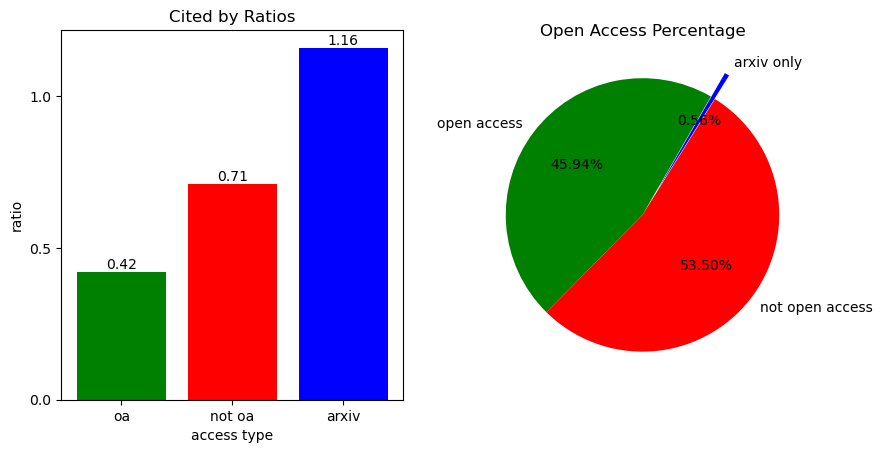

In [177]:
fig, (ax1, ax2) = plt.subplots(
    1, 2,
)
textprops = {"fontsize": 10}
ax2.pie(
    [
        oa_percentage,
        not_oa_percentage,
        arxiv_only_percentage
    ],
    labels=[
        'open access',
        'not open access',
        'arxiv only'
    ],
    explode=[0, 0, 0.2],
    autopct='%1.2f%%',
    startangle=60,
    textprops=textprops,
    colors=['green', 'red', 'blue']
)
ax2.set_title('Open Access Percentage')

bars = ax1.bar(
    ['oa', 'not oa', 'arxiv'],
    [oa_cited_ratio, not_oa_cited_ratio, arxiv_ratio],
    color=['green', 'red', 'blue']
)
for bar, value in zip(bars, [oa_cited_ratio, not_oa_cited_ratio, arxiv_ratio]):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        value,
        str(value),
        ha='center',
        va='bottom'
    )

ax1.set_yticks([0, 0.5, 1])
ax1.set_ylabel('ratio')
ax1.set_xlabel('access type')
ax1.set_title('Cited by Ratios')
plt.subplots_adjust(right=1.3)
plt.show()

<a name="analy_7_2"></a>
#### Funding Percentages

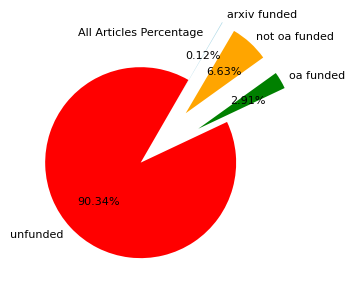

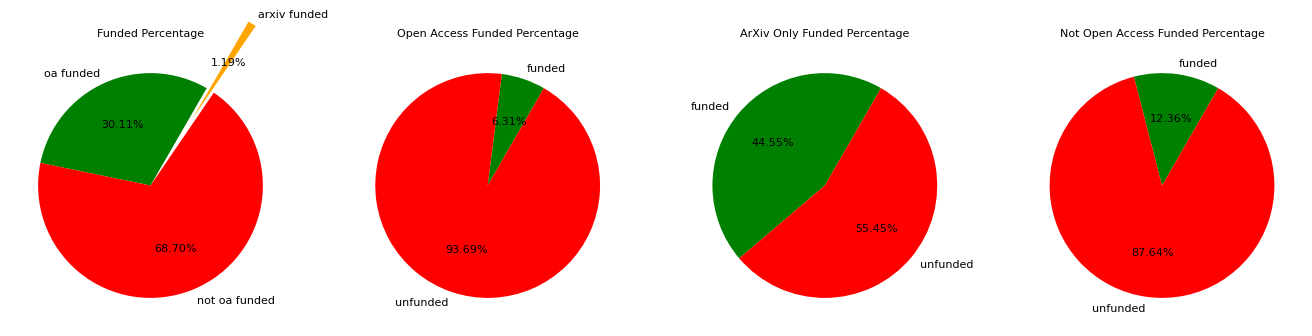

In [178]:
textprops = {"fontsize": 8}
fig0, (ax0) = plt.subplots(
    1, 1,
    figsize=(3.1, 3.1)
)

ax0.pie(
    [
        unfunded_p, oa_funded_p, not_oa_funded_p, arxiv_funded_p
    ],
    labels=[
        'unfunded', 'oa funded', 'not oa funded', 'arxiv funded'
    ],
    explode=[0, 0.7, 0.7, 0.7],
    autopct='%1.2f%%',
    startangle=60,
    textprops=textprops,
    colors=['red', 'green', 'orange', 'lightblue'],
)
ax0.set_title('All Articles Percentage', fontsize=8)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(
    1, 4,
    figsize=(11, 11)
)

ax1.pie(
    [
        df_fund_oa.iloc[0, 1]/funded_articles*100,
        df_fund_not_oa.iloc[0, 1]/funded_articles*100,
        df_fund_arxiv.iloc[0, 1]/funded_articles*100,
    ],
    labels=[
        'oa funded', 'not oa funded', 'arxiv funded'
    ],
    explode=[0, 0, 0.7],
    autopct='%1.2f%%',
    startangle=60,
    textprops=textprops,
    colors=['green', 'red', 'orange']
)
ax1.set_title('Funded Percentage', fontsize=8)

ax2.pie(
    [
        oa_funded_percentage,
        100-oa_funded_percentage,
    ],
    labels=[
        'funded',
        'unfunded',
    ],
    autopct='%1.2f%%',
    startangle=60,
    textprops=textprops,
    colors=['green', 'red']
)
ax2.set_title('Open Access Funded Percentage', fontsize=8)

ax3.pie(
    [
        arxiv_funded_percentage,
        100-arxiv_funded_percentage,
    ],
    labels=[
        'funded',
        'unfunded',
    ],
    autopct='%1.2f%%',
    startangle=60,
    textprops=textprops,
    colors=['green', 'red']
)
ax3.set_title('ArXiv Only Funded Percentage', fontsize=8)

ax4.pie(
    [
        not_oa_funded_percentage,
        100-not_oa_funded_percentage,
    ],
    labels=[
        'funded',
        'unfunded',
    ],
    autopct='%1.2f%%',
    startangle=60,
    textprops=textprops,
    colors=['green', 'red']
)
ax4.set_title('Not Open Access Funded Percentage', fontsize=8)

plt.subplots_adjust(right=1.3)
plt.show()

[ref]: #top
[top][ref]

<a name="analy_7_3"></a>
#### Top 5 Insights

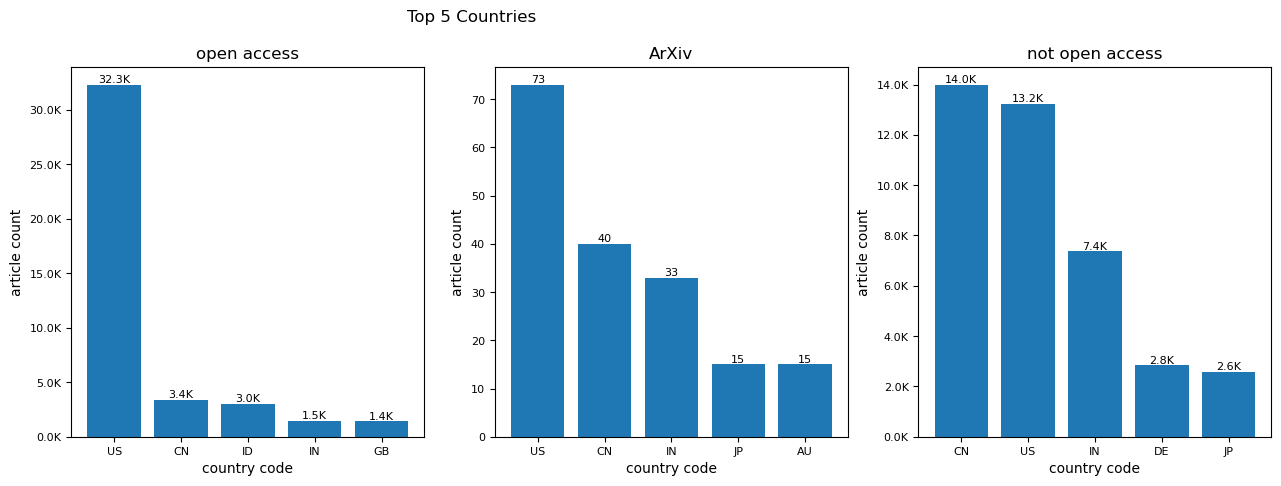

In [179]:
fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3,
)
ax1.bar(top_5_c_oa.index, top_5_c_oa.values)
ax1.set_xlabel("country code")
ax1.set_ylabel("article count")
ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)
ax1.yaxis.set_major_formatter(thousand_formatter)
for i in ax1.containers:
    ax1.bar_label(i, fmt=thousand_formatter, fontsize=8)

ax2.bar(top_5_c_arx.index, top_5_c_arx.values)
ax2.set_xlabel("country code")
ax2.set_ylabel("article count")
ax2.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)
for i in ax2.containers:
    ax2.bar_label(i, fontsize=8)

ax3.bar(top_5_c_not_oa.index, top_5_c_not_oa.values)
ax3.set_xlabel("country code")
ax3.set_ylabel("article count")
ax3.tick_params(axis='x', labelsize=8)
ax3.tick_params(axis='y', labelsize=8)
ax3.yaxis.set_major_formatter(thousand_formatter)
for i in ax3.containers:
    ax3.bar_label(i, fmt=thousand_formatter, fontsize=8)

suptitle = plt.suptitle('Top 5 Countries')
suptitle.set_position([0.75, 1])

ax1.set_title('Open Access')
ax2.set_title('ArXiv Only')
ax3.set_title('Not open access')

plt.subplots_adjust(right=2)
plt.show()

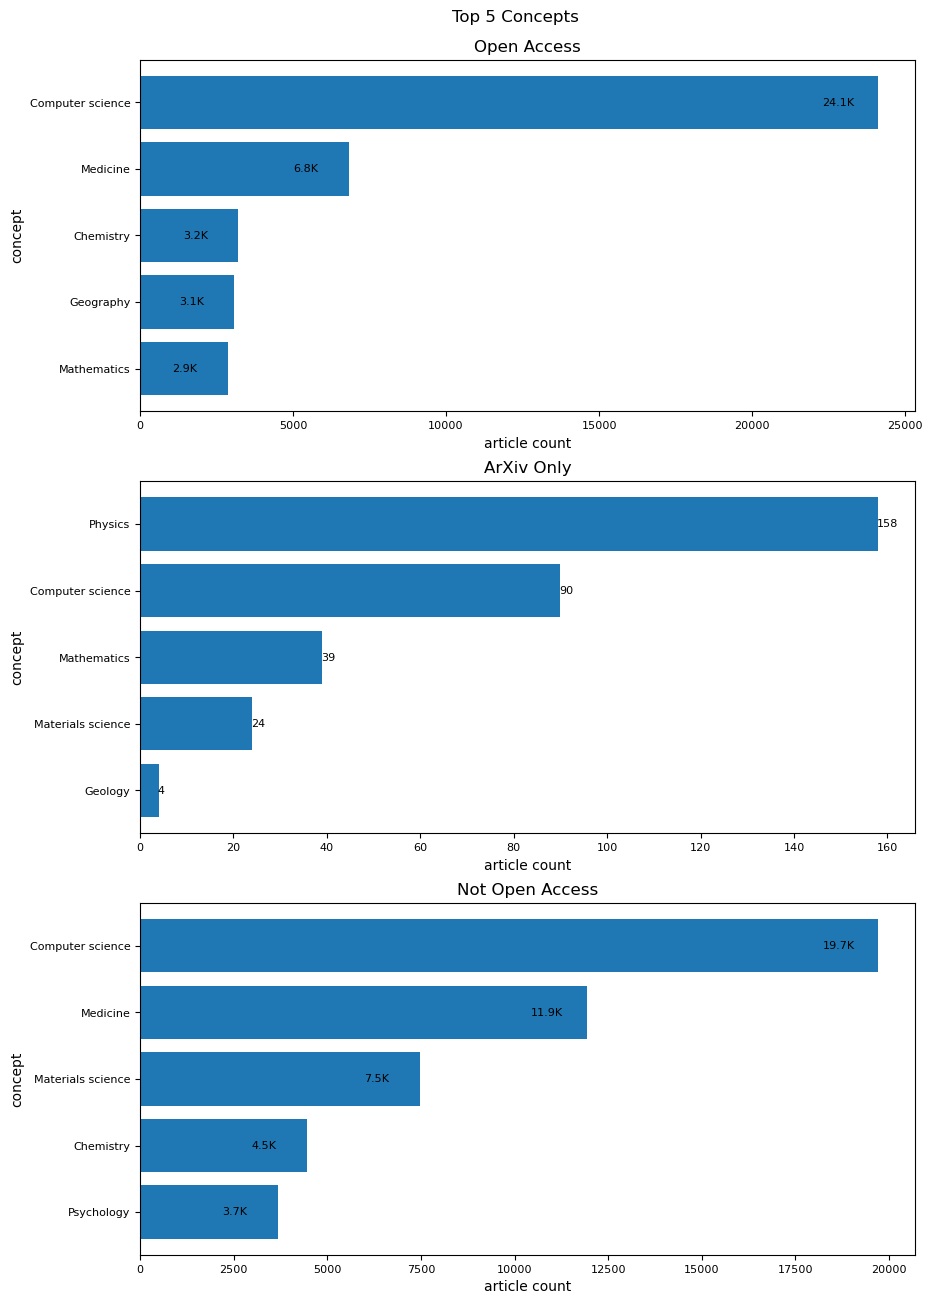

In [180]:
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1,
    figsize=(10, 5)
)
ax1.barh(top_5_con_oa.index, top_5_con_oa.values)
ax1.set_ylabel("concept")
ax1.set_xlabel("article count")
ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)
for i in ax1.containers:
    ax1.bar_label(i, fmt=thousand_formatter, padding=-40, fontsize=8)

ax2.barh(top_5_con_arx.index, top_5_con_arx.values)
ax2.set_ylabel("concept")
ax2.set_xlabel("article count")
ax2.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)
for i in ax2.containers:
    ax2.bar_label(i, padding=-1, fontsize=8)

ax3.barh(top_5_con_not_oa.index, top_5_con_not_oa.values)
ax3.set_ylabel("concept")
ax3.set_xlabel("article count")
ax3.tick_params(axis='x', labelsize=8)
ax3.tick_params(axis='y', labelsize=8)
for i in ax3.containers:
    ax3.bar_label(i, fmt=thousand_formatter, padding=-40, fontsize=8)

suptitle = plt.suptitle('Top 5 Concepts')
suptitle.set_position([0.5, 2.6])

ax1.set_title('Open Access')
ax2.set_title('ArXiv Only')
ax3.set_title('Not Open Access')

plt.subplots_adjust(top=2.5)
plt.show()

[ref]: #top
[top][ref]

<a name="conc"></a>
## Conclusion
***
The report finds that almost half of all articles are open access, with ArXiV only contributing a small percentage of the open access contribution of new research generated from 2022 to the present.

We find that the United States, China, and Indonesia are the biggest contributors to research in the time period for both open access and paid access research work. The United States, in particular, leads the production of new open access articles by a wide margin against China but only by a small one in terms of paid access articles. India and Great Britain are also top contributors to open access articles, while Germany and Japan join the top 5 contributors for paid access articles. In all cases, the top contributors to new research in the period are from developed or rapidly developing countries, an indication of the presence of an income element to research generation. Less developed societies are thus twice disadvantaged, first by their lack of access to research barred by paywalls, and second, by their lackluster capacity to conduct research. It is therefore a welcome development that the United States 

Suprisingly, new articles that are behind a paywall are cited more times (0.71 times) than open acess articles (0.42 times), though open access articles coming specifically from ArXiv significantly gets cited more often than its open access peers (1.16 times). It is likely that new open access articles are cited less than new paid access articles because of the quality of research as its generally expected for paywall-locked articles to be better in quality compared to open access counterparts. Articles in ArXiv tend to be cited more than the other two groups, suggesting that if an article is hosted in ArXiv, then it should be a top tier article to cite. It bears noting, however, that these citation numbers may change as time passes. Investigating this may be the subject of a new report.

In terms of articles with grants/funding, a significant percentage of articles are unfunded (90.34%). With respect to the subset of funded articles, it is observed that paid access articles' funding percentage is significantly high (68.70%), which may contribute to the quality of paid access research work. Finally, of all the partitions ArXiv articles are getting good funding (44.55% funded) compared to open access (6.31% funded) and paid access (12.36%) in general. If paid access articles are, indeed, of higher quality than open access ones, it is unfortunate that some quality knowledge offered by paid access articles are locked behind financial barriers.

As for research themes, computer science, a field closely related to technological development, dominates both the open access and paid access research space. Because the pace of technological advancement depends on how freely knowledge resources are generated, transferred, and spilled over, it is not surprising to see this field dominating both the open research and paid access research space. It is also a positive development that a large chunk of computer science research is available to use for free. For ArXiV-indexed articles, research work on physics form the top research theme, followed by computer science. Medicine is the second most popular field of research, though there are fewer open access articles on medicine than paid. Chemistry also makes an appearance in both open access and paid access research index in OpenAlex.

The results indicate positive developments for open access research in the world. However, there is room for improvement. It is shown that the United States is, by a vast margin, the biggest contributor to open access research in the world. This may be because the United States simply produces a sheer volume of research work. Nevertheless, the rest of the world should do more in terms of doing open access research. More open access research in crucial fields such as medicine would also be more beneficial to the world.

[ref]: #top
[top][ref]

<a name="rfn"></a>
## References
***

[1] https://openalex.org/https://openalex.org/

[ref]: #top
[top][ref]

In [206]:
db_conn.close()